# Basketball Betting

### Project Overview

This project aims to leverage machine learning techniques to predict NBA game outcomes and scores, with a particular focus on enhancing sports betting strategies. By analyzing detailed player performance statistics and game results, we develop models that can predict whether the home team will win or lose, as well as the exact final score of the game. Our approach uses various classifiers and regressors to capture the complex interactions between player performances and game outcomes. The ultimate goal is to provide accurate and actionable insights for basketball betting enthusiasts and professionals.

The project is structured into several key steps, including data collection, preprocessing, feature extraction, model training, and evaluation. We also implement a user-friendly interface that allows users to input player names and receive predictions on game outcomes and scores. This comprehensive analysis and modeling effort showcases the power of machine learning in the realm of sports analytics and betting.


### Importing Libraries
We start by importing the necessary libraries for our project. These include:
- `pandas` for data manipulation and analysis,
- `tqdm` for progress bars,
- `numpy` for numerical operations,
- `sklearn` for machine learning models,
- `matplotlib` and `seaborn` for data visualization.

In [21]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import copy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score

We load the game data from a CSV file into a DataFrame and display the first few rows to understand its structure.

In [22]:
games_df = pd.read_csv('games.csv')
games_df.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-12-22,22200477,Final,1610612740,1610612759,2022,1610612740,126.0,0.484,0.926,...,25.0,46.0,1610612759,117.0,0.478,0.815,0.321,23.0,44.0,1
1,2022-12-22,22200478,Final,1610612762,1610612764,2022,1610612762,120.0,0.488,0.952,...,16.0,40.0,1610612764,112.0,0.561,0.765,0.333,20.0,37.0,1
2,2022-12-21,22200466,Final,1610612739,1610612749,2022,1610612739,114.0,0.482,0.786,...,22.0,37.0,1610612749,106.0,0.470,0.682,0.433,20.0,46.0,1
3,2022-12-21,22200467,Final,1610612755,1610612765,2022,1610612755,113.0,0.441,0.909,...,27.0,49.0,1610612765,93.0,0.392,0.735,0.261,15.0,46.0,1
4,2022-12-21,22200468,Final,1610612737,1610612741,2022,1610612737,108.0,0.429,1.000,...,22.0,47.0,1610612741,110.0,0.500,0.773,0.292,20.0,47.0,0


### Exploratory Data Analysis

We calculate the average points scored by home and away teams for each season and plot this data to observe trends over time.

/Users/atirumalai/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/atirumalai/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/atirumalai/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/atirumalai/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

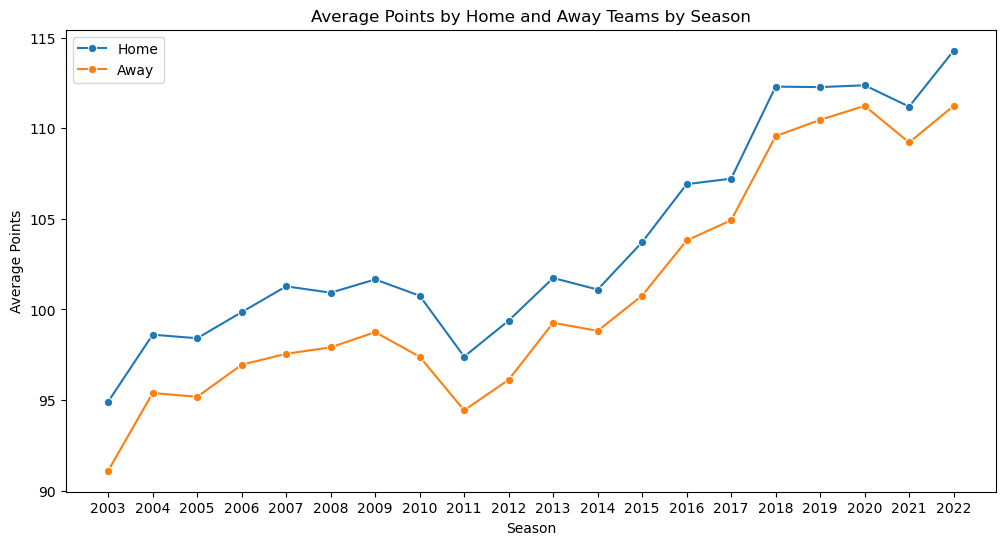

In [23]:
# Convert SEASON to integer
games_df['SEASON'] = games_df['SEASON'].astype(int)

# Calculate the average points by home and away teams by season
avg_points_by_season = games_df.groupby('SEASON')[['PTS_home', 'PTS_away']].mean()

# Plot the average points by home and away teams by season
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_points_by_season.reset_index(), x='SEASON', y='PTS_home', marker='o', label='Home')
sns.lineplot(data=avg_points_by_season.reset_index(), x='SEASON', y='PTS_away', marker='o', label='Away')
plt.title('Average Points by Home and Away Teams by Season')
plt.xlabel('Season')
plt.ylabel('Average Points')
plt.xticks(avg_points_by_season.index)  # Ensure x-axis ticks are integers
plt.legend()
plt.show()

The line graph above illustrates the average points scored by home and away teams in NBA games from the 2002-2003 season to the 2021-2022 season. Several key trends and observations can be made from this data:

1. **Overall Increase in Scoring**:
   - Both home and away teams have seen a notable increase in average points scored per game over the analyzed seasons. This trend reflects changes in the style of play in the NBA, which has increasingly favored faster-paced, higher-scoring games.

2. **Home Court Advantage**:
   - Throughout the entire period, home teams consistently scored more points on average than away teams. This phenomenon, known as "home court advantage," is well-documented in sports and can be attributed to factors such as familiar surroundings, supportive fans, and reduced travel fatigue.

3. **Seasonal Variations**:
   - There are fluctuations in scoring trends across different seasons. Notable dips can be observed in the 2011-2012 season, which coincides with a lockout that shortened the season and could have impacted player performance and game dynamics.
   - A significant increase in scoring is observed starting around the 2016-2017 season, aligning with strategic shifts in the league, such as the emphasis on three-point shooting and offensive efficiency.

4. **Recent Highs**:
   - The last few seasons (2019-2022) show the highest average points per game for both home and away teams, peaking in the 2021-2022 season. This peak could be due to continued strategic evolution in the game and rule changes favoring offensive play.

5. **Consistent Home Advantage**:
   - The gap between home and away teams' average points remains fairly consistent throughout the years, indicating that while both have improved their scoring abilities, the relative advantage of playing at home has persisted.

Now, we plot a visual representation of the distribution of points scored by home and away teams in NBA games over all seasons:

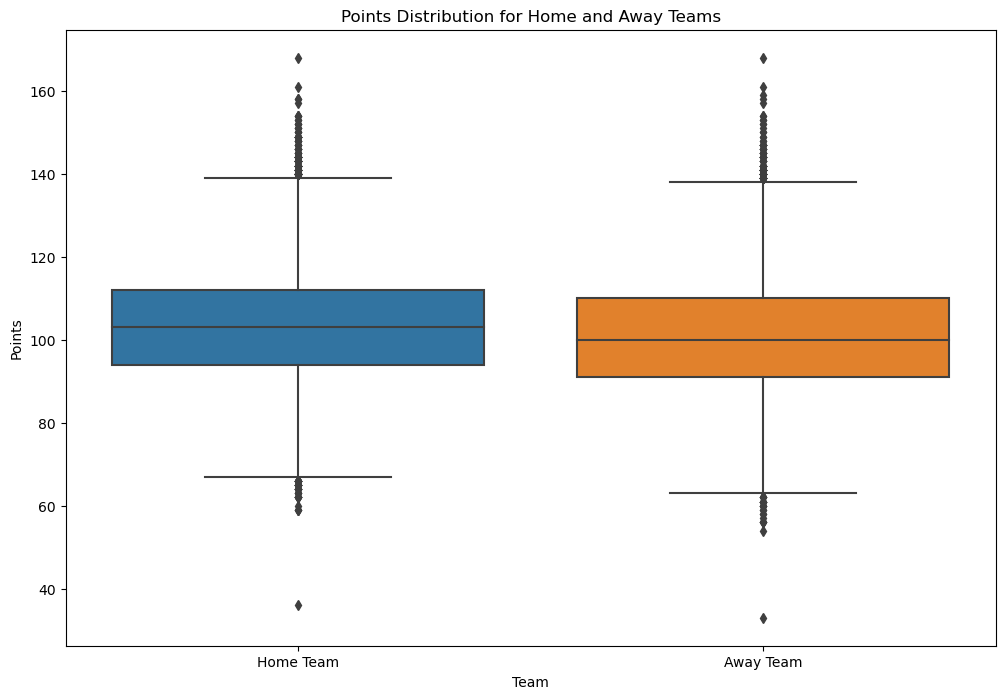

In [24]:
# Plot box plots of points distribution for home and away teams
plt.figure(figsize=(12, 8))
sns.boxplot(data=games_df[['PTS_home', 'PTS_away']])
plt.title('Points Distribution for Home and Away Teams')
plt.xlabel('Team')
plt.ylabel('Points')
plt.xticks([0, 1], ['Home Team', 'Away Team'])
plt.show()

Several key observations can be made from this plot:

1. **Central Tendency**:
   - The median points scored by home teams is slightly higher than that of away teams, as indicated by the central line in each box. This reaffirms the home court advantage observed in the previous analysis.
   
2. **Interquartile Range (IQR)**:
   - The interquartile range, which represents the middle 50% of the data, is similar for both home and away teams. This suggests that the typical spread of points scored in games is comparable for both groups.
   
3. **Outliers**:
   - Both home and away teams have outliers on the high and low ends. There are several instances where teams scored significantly more or fewer points than usual. The presence of these outliers highlights the variability and unpredictability inherent in basketball games.
   - Notably, there are more high-end outliers for home teams, indicating that home teams are more likely to have exceptionally high-scoring games compared to away teams.
   
4. **Whiskers**:
   - The whiskers of the box plot extend to the minimum and maximum values within 1.5 times the IQR from the quartiles. For both home and away teams, the lower whisker reaches down to around 60 points, while the upper whisker reaches up to approximately 140 points for home teams and slightly lower for away teams.

5. **Overall Spread**:
   - The overall spread of points is broader for home teams, as evidenced by the longer whiskers and more outliers. This suggests that while home teams have a higher average and median score, their performance is also more variable compared to away teams.

To further analyze the relation between home and away teams in NBA games, let us plot the win rate of home teams across all seasons.

/Users/atirumalai/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/atirumalai/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


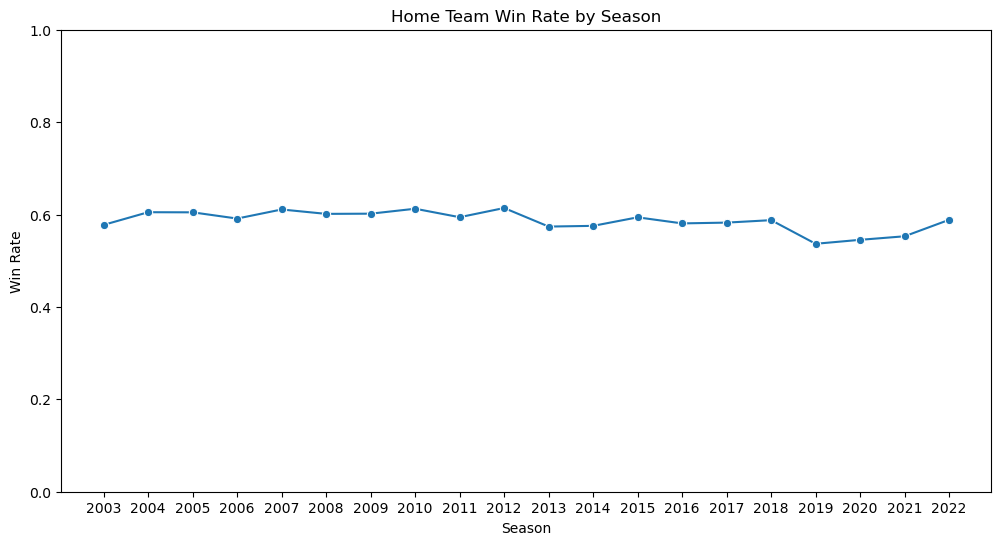

In [25]:
# Convert SEASON to integer
games_df['SEASON'] = games_df['SEASON'].astype(int)

# Calculate the win rate by season
win_rate_by_season = games_df.groupby('SEASON')['HOME_TEAM_WINS'].mean()

# Plot the home team win rate by season
plt.figure(figsize=(12, 6))
sns.lineplot(x=win_rate_by_season.index, y=win_rate_by_season.values, marker='o')
plt.title('Home Team Win Rate by Season')
plt.xlabel('Season')
plt.ylabel('Win Rate')
plt.ylim(0, 1)
plt.xticks(win_rate_by_season.index)  # Ensure x-axis ticks are integers
plt.show()

Here are the key observations and analysis from this graph:

1. **Consistent Home Advantage**:
   - Over the entire period, the home team win rate fluctuates around the 0.6 mark, indicating that home teams win approximately 60% of their games on average. This consistency underscores the well-known home court advantage in the NBA.

2. **Fluctuations in Win Rate**:
   - There are minor fluctuations in the win rate across seasons. The win rate dips slightly below 0.6 in some seasons, such as 2011-2012 and 2019-2020, while rising above 0.6 in others, such as 2012-2013 and 2021-2022.
   - These fluctuations could be influenced by various factors, including changes in team compositions, injuries to key players, and shifts in playing styles or strategies.

3. **Impact of External Factors**:
   - The 2011-2012 season saw a slight dip in the home team win rate, which could be attributed to the shortened season due to the lockout, affecting team dynamics and performance.
   - Similarly, the 2019-2020 season experienced a noticeable drop in win rate, potentially influenced by the COVID-19 pandemic, which disrupted the regular season and led to games being played in a bubble environment without traditional home court advantages.

4. **Recent Trends**:
   - In the last few seasons, there is a slight upward trend in the home team win rate, with the 2021-2022 season showing a return to around 0.6. This suggests a stabilization or recovery of the home court advantage post-pandemic disruptions.

5. **Historical Stability**:
   - Despite the fluctuations, the overall stability of the win rate around 0.6 highlights the persistent impact of playing at home. This stability reflects the advantages home teams typically enjoy, such as familiar playing conditions, supportive crowds, and reduced travel fatigue.


Now that we have understood the various trends and patterns in our data through exploratory data analysis, we are ready to proceed with the next step: data preprocessing. This step involves cleaning and preparing our data to ensure it is suitable for training our machine learning models. Proper preprocessing will help us address any inconsistencies, handle missing values, and transform the data into a format that can be efficiently used by our algorithms.

### Data Preprocessing

In [26]:
details_df = pd.read_csv('games_details.csv')
details_df.head()

/var/folders/y5/3b7y1ppj1dq4pv5pyd26ts0h0000gn/T/ipykernel_41199/1978113452.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  details_df = pd.read_csv('games_details.csv')


,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,22200477,1610612759,SAS,San Antonio,1629641,Romeo Langford,Romeo,F,NaN,18:06,...,1.0,1.0,2.0,0.0,1.0,0.0,2.0,5.0,2.0,-2.0
1,22200477,1610612759,SAS,San Antonio,1631110,Jeremy Sochan,Jeremy,F,NaN,31:01,...,6.0,3.0,9.0,6.0,1.0,0.0,2.0,1.0,23.0,-14.0
2,22200477,1610612759,SAS,San Antonio,1627751,Jakob Poeltl,Jakob,C,NaN,21:42,...,1.0,3.0,4.0,1.0,1.0,0.0,2.0,4.0,13.0,-4.0
3,22200477,1610612759,SAS,San Antonio,1630170,Devin Vassell,Devin,G,NaN,30:20,...,0.0,9.0,9.0,5.0,3.0,0.0,2.0,1.0,10.0,-18.0
4,22200477,1610612759,SAS,San Antonio,1630200,Tre Jones,Tre,G,NaN,27:44,...,0.0,2.0,2.0,3.0,0.0,0.0,2.0,2.0,19.0,0.0


To focus our analysis on more recent data, we filter out games that occurred before the 2017 season. This reduces the size of our dataset and ensures that our models are trained on relevant and current data.

In [27]:
#For space considerations, we drop all games prior to 2017
drop_ids = [] 
for index, row in games_df.iterrows():
    year_str = row['GAME_DATE_EST']
    year = int(year_str[0:4])
    if(year < 2017):
        drop_ids.append(row['GAME_ID'])

games_df = games_df[~games_df['GAME_ID'].isin(drop_ids)]
details_df = details_df[~details_df['GAME_ID'].isin(drop_ids)]

games_df.reset_index(drop=True, inplace=True)
details_df.reset_index(drop=True, inplace=True)

We initialize a dictionary to store player statistics for each game they played. This structure will help us track individual player performances across multiple games.

In [28]:
num_rows = details_df.shape[0]
# Initialize the data structure
player_stats = {}


# Construct the data structure
for index, row in tqdm(details_df.iterrows(), total=num_rows, desc="Processing rows"):
    player_name = row['PLAYER_NAME']
    game_id = row['GAME_ID']
    player_statistics = row.drop(['PLAYER_NAME', 'GAME_ID', 'TEAM_ID', 'TEAM_CITY', 'PLAYER_ID', 'NICKNAME','START_POSITION','COMMENT','TEAM_ABBREVIATION'])
    if player_statistics.isnull().any():
        continue
    player_statistics = player_statistics.to_dict()
    if player_name not in player_stats:
        player_stats[player_name] = {}
    
    player_stats[player_name][game_id] = player_statistics

Processing rows: 100%|██████████| 208536/208536 [00:18<00:00, 11409.03it/s]


We create a dictionary to maintain a sorted list of game IDs for each player. This will make it easier to look up the previous three games for any player.

In [29]:
player_games_sorted = {}
for index, row in tqdm(details_df.iterrows(), total=num_rows, desc="Processing rows"):
    player_name = row['PLAYER_NAME']
    game_id = row['GAME_ID']

    if player_name not in player_games_sorted:
        player_games_sorted[player_name] = [game_id]
    else:
        player_games_sorted[player_name].append(game_id)
        player_games_sorted[player_name].sort()

Processing rows: 100%|██████████| 208536/208536 [00:02<00:00, 75145.91it/s]


We define a function to convert player statistics dictionary entries into numpy arrays. This conversion will facilitate numerical operations and model training.

In [30]:
def dict_entry_to_numpy(dict_entry):
    time_str = dict_entry['MIN']
    try:
        if ':' in time_str:
            minutes, seconds = map(int, time_str.split(':'))
            total_minutes = minutes * 60 + seconds
        else:
            total_minutes = float(time_str) * 60  # Assuming it's in minutes as a float
    except ValueError:
        total_minutes = 0.0  # Default to 0 if the format is incorrect or missing

    new_entry = dict_entry.copy()
    new_entry['MIN'] = total_minutes
    values_array = np.array(list(new_entry.values()))
    return values_array

We define a function to find the statistics for the past three games of a player. This function is crucial for creating input tensors that capture recent player performance.

In [31]:
# Function to find past three game IDs
def findPastThreeIDs(player_name, target_game=None):
    if player_name not in player_games_sorted:
        return np.zeros(20 * 3)  # Assuming each entry has 20 features and we need three entries
    foundarr = []
    for game_id in player_games_sorted[player_name]:
        if game_id == target_game:
            break
        try:
            foundarr.append(dict_entry_to_numpy(player_stats[player_name][game_id]))
        except KeyError:
            continue
    if len(foundarr) < 3:
        return np.concatenate([np.zeros(20)] * (3 - len(foundarr)) + foundarr)
    return np.concatenate(foundarr[-3:])

The following is example usage of the above function, getting the tensor for a player and the three previous starting games before the one specified.

In [32]:
findPastThreeIDs("Romeo Langford", 22200477)

array([ 1.719e+03,  7.000e+00,  1.000e+01,  7.000e-01,  1.000e+00,
        2.000e+00,  5.000e-01,  4.000e+00,  4.000e+00,  1.000e+00,
        1.000e+00,  5.000e+00,  6.000e+00,  0.000e+00,  1.000e+00,
        1.000e+00,  2.000e+00,  3.000e+00,  1.900e+01, -3.000e+00,
        1.491e+03,  1.000e+00,  5.000e+00,  2.000e-01,  0.000e+00,
        2.000e+00,  0.000e+00,  1.000e+00,  2.000e+00,  5.000e-01,
        2.000e+00,  1.000e+00,  3.000e+00,  1.000e+00,  1.000e+00,
        1.000e+00,  0.000e+00,  1.000e+00,  3.000e+00, -1.200e+01,
        1.154e+03,  2.000e+00,  2.000e+00,  1.000e+00,  1.000e+00,
        1.000e+00,  1.000e+00,  1.000e+00,  2.000e+00,  5.000e-01,
        0.000e+00,  1.000e+00,  1.000e+00,  1.000e+00,  0.000e+00,
        1.000e+00,  0.000e+00,  1.000e+00,  6.000e+00,  3.000e+00])

We define a function to get the tensor for a specific game by combining the statistics of starting players. This tensor serves as the input for our machine learning models.

In [33]:
# Function to get tensor from game ID
def getTensorFromID(id, game_details_df):
    filtered_df = game_details_df[(game_details_df['GAME_ID'] == id) & (game_details_df['START_POSITION'].notna())]
    tensor = np.array([], dtype=float)
    for index, row in filtered_df.iterrows():
        player_tensor = findPastThreeIDs(row['PLAYER_NAME'], id)
        tensor = np.concatenate((tensor, player_tensor))
    return tensor 

Example usage of the above function. This allows us to get an input tensor for a specfied game. So, to train on data, simply run this function to get all input points on the games you want to train on. 

In [34]:
getTensorFromID(22200477, details_df)

array([ 1.719e+03,  7.000e+00,  1.000e+01,  7.000e-01,  1.000e+00,
        2.000e+00,  5.000e-01,  4.000e+00,  4.000e+00,  1.000e+00,
        1.000e+00,  5.000e+00,  6.000e+00,  0.000e+00,  1.000e+00,
        1.000e+00,  2.000e+00,  3.000e+00,  1.900e+01, -3.000e+00,
        1.491e+03,  1.000e+00,  5.000e+00,  2.000e-01,  0.000e+00,
        2.000e+00,  0.000e+00,  1.000e+00,  2.000e+00,  5.000e-01,
        2.000e+00,  1.000e+00,  3.000e+00,  1.000e+00,  1.000e+00,
        1.000e+00,  0.000e+00,  1.000e+00,  3.000e+00, -1.200e+01,
        1.154e+03,  2.000e+00,  2.000e+00,  1.000e+00,  1.000e+00,
        1.000e+00,  1.000e+00,  1.000e+00,  2.000e+00,  5.000e-01,
        0.000e+00,  1.000e+00,  1.000e+00,  1.000e+00,  0.000e+00,
        1.000e+00,  0.000e+00,  1.000e+00,  6.000e+00,  3.000e+00,
        1.289e+03,  2.000e+00,  6.000e+00,  3.330e-01,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        1.000e+00,  4.000e+00,  5.000e+00,  3.000e+00,  0.000e

### Creating and Running ML Models

First, we prepare the training data by constructing input tensors for each game and corresponding labels for the classification and regression tasks. This involves iterating through each game and creating the necessary tensors and labels.

To ensure all tensors have consistent shapes, we pad them to the length of the longest tensor. This step is crucial for the models to process the input data correctly.

We split the data into training and testing sets for both classification and regression tasks. This allows us to evaluate our models on unseen data.

In [35]:
# Preparing training data
input_tensors = []
output_labels = []
output_scores = []

for index, row in tqdm(games_df.iterrows(), total=games_df.shape[0], desc="Preparing training data"):
    game_id = row['GAME_ID']
    home_team_wins = 1 if row['HOME_TEAM_WINS'] else 0
    home_team_score = row['PTS_home']
    away_team_score = row['PTS_away']
    
    tensor = getTensorFromID(game_id, details_df)
    input_tensors.append(tensor)
    output_labels.append(home_team_wins)
    output_scores.append([home_team_score, away_team_score])

# Determine the maximum tensor length
max_length = max(len(tensor) for tensor in input_tensors)

# Pad tensors to ensure consistent shape
def pad_tensor(tensor, max_length):
    padding = max(0, max_length - len(tensor))
    return np.pad(tensor, (0, padding), 'constant')

input_tensors = [pad_tensor(tensor, max_length) for tensor in input_tensors]

# Convert to numpy arrays
X = np.array(input_tensors)
y = np.array(output_labels)
y_scores = np.array(output_scores)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_scores, X_test_scores, y_train_scores, y_test_scores = train_test_split(X, y_scores, test_size=0.2, random_state=42)

Preparing training data: 100%|██████████| 7984/7984 [00:54<00:00, 146.52it/s]


We train a Random Forest Classifier to predict whether the home team will win or lose. This model uses the input tensors to learn patterns in the data.

We train a Random Forest Regressor to predict the scores of the home and away teams. This model helps us estimate the actual game scores based on player performance.

Since performing GridSearch to obtain the optimal values of the hyperparameters took too long to run (>30 minutes), we decided to manually test different values of the hyperparameter and pick the best one. We ultimately landed on 200 trees as giving the best accuracy and MSE. 

In [36]:
# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, verbose=False)
clf.fit(X_train, y_train)

# Evaluate the classifier on the test data
y_test_pred = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Classifier Accuracy: {test_accuracy:.2f}')

# Train Random Forest Regressor
reg = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1, verbose=False)
reg.fit(X_train_scores, y_train_scores)

# Evaluate the regressor on the test data
y_test_pred_scores = reg.predict(X_test_scores)
test_mse = mean_squared_error(y_test_scores, y_test_pred_scores)
print(f'Test Regressor Mean Squared Error: {test_mse:.2f}')

Test Classifier Accuracy: 0.59
Test Regressor Mean Squared Error: 150.42


**Interpretation of Metrics**

1. **Test Regressor Mean Squared Error: 150.42**
   - The Mean Squared Error (MSE) of 150.42 for the regressor indicates the average squared difference between the predicted and actual scores. A lower MSE value represents better predictive accuracy, as it means the predicted scores are closer to the actual scores.
   
   - In practical terms, this MSE value means that on average, the squared error in our score predictions is 150.42 points. This metric helps us understand the precision of our score predictions, and while there is room for improvement, it provides a solid foundation for refining our models.


To evaluate the performance of our classifier, we generate a confusion matrix and calculate key metrics such as accuracy, precision, and recall.

<Figure size 1000x700 with 0 Axes>

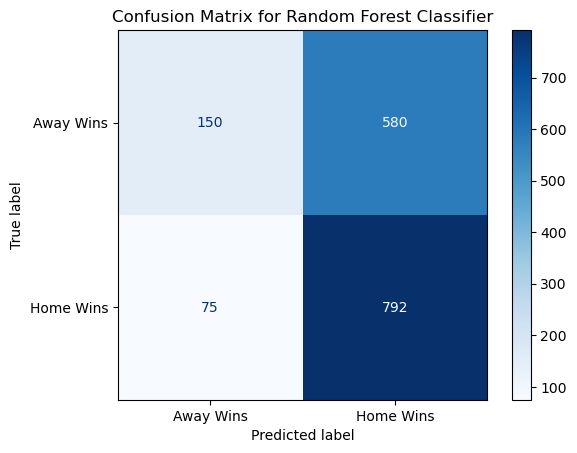

In [37]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Away Wins', 'Home Wins'])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

In [38]:
# Calculate accuracy, precision, and recall
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

Accuracy: 0.59
Precision: 0.58
Recall: 0.91


**Interpretation of metrics**
1. **Test Classifier Accuracy: 0.59**
   - The classifier accuracy of 0.59 means that our Random Forest Classifier correctly predicts the outcome of a game (home team win or loss) 59% of the time. In other words, out of 100 games, the model is expected to predict around 59 game outcomes correctly.

   - While this might not seem exceptionally high compared to typical standards in other applications, an accuracy of 59% is quite valuable in the context of sports betting. In gambling, the baseline accuracy for predicting a binary outcome (like win/loss) is 50%, which represents random guessing. An accuracy of 59% indicates that our model performs significantly better than random chance, giving us an edge in making betting decisions. Consistently achieving a 59% win rate can lead to sustainable profits in the long term. In gambling, even a small edge can compound over time, leading to significant gains.

2. **Precision: 0.58**
   - A precision of 0.58 indicates that our model is reasonably good at correctly identifying home team wins. This is important in betting because it means that when our model predicts a home team will win, there is a better-than-random chance (58%) that this prediction is accurate.

   - A precision of 0.58 strikes a balance by providing a higher likelihood of successful bets compared to random guessing.

3. **Recall: 0.91**
   - A high recall of 0.91 ensures that our model captures most of the home team wins. This is crucial in betting because missing out on potential wins (false negatives) can mean lost opportunities for profit. By correctly identifying 91% of the actual home team wins, our model ensures that we take advantage of most winning situations.

   - High recall means the model is thorough in its predictions, minimizing the chances of missing out on actual home team wins. This comprehensive coverage is important for long-term profitability in betting, as it maximizes the number of correct predictions over time.

### Predicting Game Outcomes and Scores Based on User Input

We define a function to predict the outcome and scores of a game based on input player statistics. This function processes the input data, constructs the necessary tensor, and uses the trained models to make predictions.

In [39]:
def predict_game_outcome_and_score(home_team_players, away_team_players):
    home_tensor = np.array([], dtype=float)
    away_tensor = np.array([], dtype=float)
    
    for player in home_team_players:
        home_tensor = np.concatenate((home_tensor, findPastThreeIDs(player, None)))
    
    for player in away_team_players:
        away_tensor = np.concatenate((away_tensor, findPastThreeIDs(player, None)))
    
    home_tensor = pad_tensor(home_tensor, max_length // 2)
    away_tensor = pad_tensor(away_tensor, max_length // 2)
    
    input_tensor = np.concatenate((home_tensor, away_tensor)).reshape(1, -1)
    
    scores = reg.predict(input_tensor)[0]
    home_team_score, away_team_score = int(round(scores[0])), int(round(scores[1]))
    
    # Determine the outcome based on predicted scores
    outcome = 1 if home_team_score > away_team_score else 0
    
    return outcome, (home_team_score, away_team_score)

We handle user input for home and away team players and use our prediction function to determine the game outcome and scores. This allows users to input any combination of players and see the predicted results.

We prompt the user to input the names of the home and away team players. The input is processed using the parameters of the model to predict the game outcome and scores.

In [40]:
def predict_game_outcome_and_score(home_team_players, away_team_players):
    max_players = 5  # Maximum number of players in the team
    
    if len(home_team_players) > max_players or len(away_team_players) > max_players:
        print("Error: More than 5 players entered on a team.")
        return None, None
    
    home_tensor = np.array([], dtype=float)
    away_tensor = np.array([], dtype=float)
    
    for player in home_team_players:
        if player not in player_stats:
            print(f"Error: Player {player} not found.")
            return None, None
        home_tensor = np.concatenate((home_tensor, findPastThreeIDs(player, None)))
    
    for player in away_team_players:
        if player not in player_stats:
            print(f"Error: Player {player} not found.")
            return None, None
        away_tensor = np.concatenate((away_tensor, findPastThreeIDs(player, None)))
    
    # Add empty tensors if less than five players are inputted
    while len(home_team_players) < max_players:
        home_tensor = np.concatenate((home_tensor, np.zeros(20 * 3)))
        home_team_players.append(None)  # To keep track of added empty tensors
    
    while len(away_team_players) < max_players:
        away_tensor = np.concatenate((away_tensor, np.zeros(20 * 3)))
        away_team_players.append(None)  # To keep track of added empty tensors
    
    home_tensor = pad_tensor(home_tensor, max_length // 2)
    away_tensor = pad_tensor(away_tensor, max_length // 2)
    
    input_tensor = np.concatenate((home_tensor, away_tensor)).reshape(1, -1)
    
    scores = reg.predict(input_tensor)[0]
    home_team_score, away_team_score = int(round(scores[0])), int(round(scores[1]))
    
    # Determine the outcome based on predicted scores
    outcome = 1 if home_team_score > away_team_score else 0
    
    return outcome, (home_team_score, away_team_score)

# User input for home and away team players
home_team_input = input("Enter the names of the home team players separated by commas: ").split(',')
away_team_input = input("Enter the names of the away team players separated by commas: ").split(',')

# Strip any leading/trailing spaces
home_team_input = [player.strip() for player in home_team_input]
away_team_input = [player.strip() for player in away_team_input]

# Predict outcome and scores
outcome, scores = predict_game_outcome_and_score(home_team_input, away_team_input)

if outcome is not None:
    print(f'Predicted Outcome: {"Home Team Wins" if outcome == 1 else "Away Team Wins"}')
    print(f'Predicted Scores: Home Team {scores[0]} - Away Team {scores[1]}')
    
# For example, you can input this in the popup that comes when you run this cell:
# Bojan Bogdanovic, Austin Rivers, Mason Plumlee, Andre Drummond, Cedi Osman
# Kevon Harris, Terry Rozier, Udonis Haslem, Kelly Olynyk, Devin Booker

Predicted Outcome: Home Team Wins
Predicted Scores: Home Team 108 - Away Team 105


Here, we see that the random forest model has predicted the home team to win by a scoreline of 108 - 105. 